In [13]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats

In [14]:
# Définition des noms fichiers, du path principal et de qques variables #

data_path = '/home/monteiro/STAGEIENM3/data_S2M/alp_flat/reanalysis/'

name_file_temp = 'Tair_1958_2018.nc'
name_file_metadata = 'others_dims_1958_2018.nc'

# Par région #

reg_NW = [1,2,3,4,5]
reg_North = [6,7,8,9,10,11,12]
reg_Central = [13,14]
reg_South = [15,16,17,18,19,20,21]
reg_Far_South = [22,23]
all_reg = [reg_NW,reg_North,reg_Central,reg_South,reg_Far_South]
all_reg_name = ['reg_NW','reg_North','reg_Central','reg_South','reg_Far_South']
range_ZS = np.arange(0,5100,300)

# Type d'altitude #
# Les tranche d'altitudes se font +- 150m

alt_plaine = [0,  300,  600] 
alt_basse = [900, 1200, 1500]
alt_moyenne = [1800, 2100, 2400, 2700]
alt_haute = [ 3000,3300, 3600, 3900, 4200, 4500, 4800]
range_ZS = [alt_plaine,alt_basse,alt_moyenne,alt_haute]
all_ZS = np.arange(0,5100,300)
range_ZS_name = [str(alt_plaine[0])+'-'+str(alt_plaine[-1]+150),str(alt_basse[0]-150)+'-'+str(alt_basse[-1]+150),str(alt_moyenne[0]-150)+'-'+str(alt_moyenne[-1]+150),str(alt_haute[0]-150)+'-'+str(alt_haute[-1])]

year = np.arange(1959,2019,1)

# Climatologie #

yr_11, yr_12 = 1961,1990
yr_21, yr_22 = 1991,2018
yr_1 = [1961,1990]
yr_2 = [1991,2018]

# Chargement des fichiers #

file_extra = xr.open_dataset(data_path+name_file_metadata)
file_extra = file_extra.isel(time =0)
file_temp = xr.open_dataset(data_path+name_file_temp)
file_temp = file_temp.Tair - 273.15


In [15]:
#######################################################################################
### Extrait des subsets de l'espace et fais l'ecart type intra categories du subset ###
#######################################################################################

# Tenter de remplacer Number of points par une dim generique
# Remplacer egalement la fonction calc_ratio par generique

def data_per_x(data,sthg,ls_sthg,ls_sthg_name,data_extra): #STHG = string de la variable, data = wat u want, ls_sthg = valeur intra catégories(liste de listes), ls_sthg_name = Nom des catégorie
    
    data_per_x = []
    std_intra_x = []
    
    for i in range(0,len(ls_sthg)):
        ds_res = data.sel(Number_of_points = iextract(data_extra,sthg,ls_sthg[i])).mean(dim='Number_of_points')
        std = data.sel(Number_of_points = iextract(data_extra,sthg,ls_sthg[i])).std(dim='Number_of_points')
        data_per_x.append(ds_res)
        std_intra_x.append(std)

    data_per_x = xr.concat(data_per_x,dim = sthg)
    data_per_x[sthg] = ls_sthg_name
    std_intra_x = xr.concat(std_intra_x,dim =sthg)
    std_intra_x[sthg] = ls_sthg_name
    
    return std_intra_x,data_per_x

### Fonction extraction des indices ###

def iextract(data,variable,extract_list): # data = file_extra, variable = 'massif_number' or 'ZS', extract_list = Quelle liste/entier altitude ou de massif
    data = data[variable]
    iextract_list = []
    for i in range(0,len(data)):
        
        if type(extract_list) == int or type(extract_list) == np.int64 :
            if data[i].values == extract_list:
                iextract_list.append(i)
                
        else:
            for j in range(0,len(extract_list)):
                if data[i].values == extract_list[j]:
                    iextract_list.append(i)
    return iextract_list

In [16]:
##########################################################
# Calcul de la moyenne mensuelle/saisonniere ou annuelle #
##########################################################

# Cut automatically the first and last years as they r incomplete

def calc_mean(data,mean_type, skipna = True):
    
    ds_mean = []
    
    if mean_type == 'month':
        
        num_index = [9,10,11,12,1,2,3,4,5,6,7,8]
        ls_name = ['Sep', 'Oct','Nov', 'Dec','Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug']

        ds_res = data.resample(time='1MS').mean(skipna = skipna)
        
        for i in range(0,len(num_index)):
            ds_month = ds_res.sel(time=ds_res['time.month'] == num_index[i])
            ds_month = ds_month.groupby('time.year').mean('time',skipna = skipna)
            ds_mean.append(ds_month)
            
        ds_mean = xr.concat(ds_mean,dim='month')
        ds_mean = ds_mean.isel(year=slice(1,-1))
        ds_mean['month'] = ls_name

    if mean_type == 'season':
        
        num_index = [11,2,5,8]
        ls_name = ['SON','DJF','MAM','JJA']

        ds_res = data.resample(time='Q-FEB').mean(skipna = skipna)
        
        for i in range(0,len(num_index)):
            ds_season = ds_res.sel(time=ds_res['time.month'] == num_index[i])
            ds_season = ds_season.groupby('time.year').mean('time',skipna = skipna)
            ds_mean.append(ds_season)
       
        ds_mean = xr.concat(ds_mean,dim='season')
        ds_mean = ds_mean.isel(year=slice(1,-1))
        ds_mean['season'] = ls_name
        
    if mean_type == 'year':

        ds_mean = data.groupby('time.year').mean(skipna = skipna)
        ds_mean = ds_mean.isel(year = slice(1,-1))
    
    return ds_mean

In [99]:
########################################
### Function Calc_trend over dataset ###
########################################

# def dataset_encoding(xds):
#     cols = ['source', 'original_shape', 'dtype', 'zlib', 'complevel', 'chunksizes']
#     info = pd.DataFrame(columns=cols, index=xds.data_vars)
#     for row in info.index:
#         var_encoding = xds[row].encoding
#         for col in info.keys():
#             info.ix[row, col] = var_encoding.pop(col, '')
    
#     return info


def xarray_trend(xarr):    
    from scipy import stats
    # getting shapes of the dataset (m = coords, n = time)
    
    m = np.prod(xarr.shape[1:]).squeeze()
    n = xarr.shape[0]
    
    # creating x and y variables for linear regression
    x = xarr.time.to_pandas().index.to_julian_date().values[:, None]
    y = xarr.to_masked_array().reshape(n, -1)
    
    # ############################ #
    # LINEAR REGRESSION DONE BELOW #
    xm = x.mean(0)  # mean
    ym = y.mean(0)  # mean
    ya = y - ym  # anomaly
    xa = x - xm  # anomaly
    
    # variance and covariances
    xss = (xa ** 2).sum(0) / (n - 1)  # variance of x (with df as n-1)
    yss = (ya ** 2).sum(0) / (n - 1)  # variance of y (with df as n-1)
    xys = (xa * ya).sum(0) / (n - 1)  # covariance (with df as n-1)
    # slope and intercept
    slope = xys / xss
    intercept = ym - (slope * xm)
    # statistics about fit
    df = n - 2
    r = xys / (xss * yss)**0.5
    t = r * (df / ((1 - r) * (1 + r)))**0.5
    p = stats.distributions.t.sf(abs(t), df)
    
    # misclaneous additional functions
    # yhat = dot(x, slope[None]) + intercept
    # sse = ((yhat - y)**2).sum(0) / (n - 2)  # n-2 is df
    # se = ((1 - r**2) * yss / xss / df)**0.5
    
    # preparing outputs
    out = xarr[:2].mean('time')
    # first create variable for slope and adjust meta
    xarr_slope = out.copy()
    xarr_slope.name += '_slope'
    xarr_slope.attrs['units'] = 'units / day'
    xarr_slope.values = slope.reshape(xarr.shape[1:])
    # do the same for the p value
    xarr_p = out.copy()
    xarr_p.name += '_Pvalue'
    xarr_p.attrs['info'] = "If p < 0.05 then the results from 'slope' are significant."
    xarr_p.values = p.reshape(xarr.shape[1:])
    # join these variables
    xarr_out = xarr_slope.to_dataset(name='slope')
    xarr_out['pval'] = xarr_p

    return xarr_out

In [101]:
#############################################
### Calculate Trend over altitudes levels ###
#############################################

Tair_per_alt = data_per_x(file_temp,'ZS',range_ZS,range_ZS_name,file_extra)
LR_per_alt = xarray_trend(Tair_per_alt[1].transpose())
Slope_per_alt = LR_per_alt.slope*365*10
Slope_per_alt

<xarray.DataArray 'slope' (ZS: 4)>
array([0.01526757, 0.15034017, 0.22194173, 0.10223521])
Coordinates:
  * ZS       (ZS) <U9 '0-750' '750-1650' '1650-2850' '2850-4800'

In [6]:
data_season = calc_mean(file_temp,'season')
data_month = calc_mean(file_temp,'month')

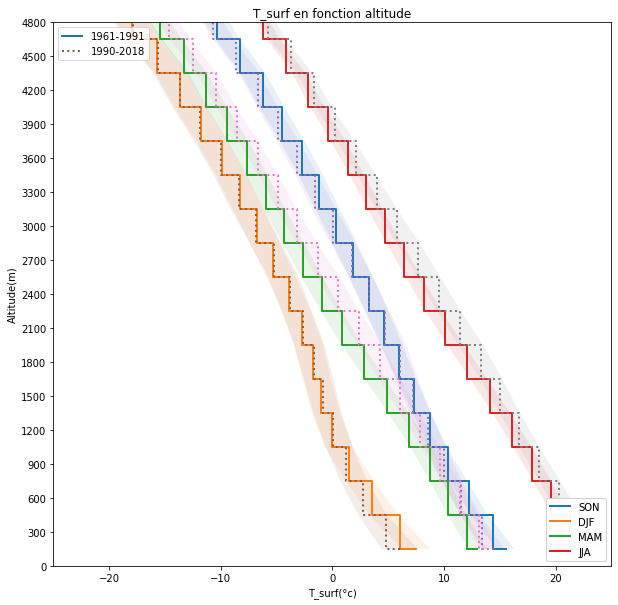

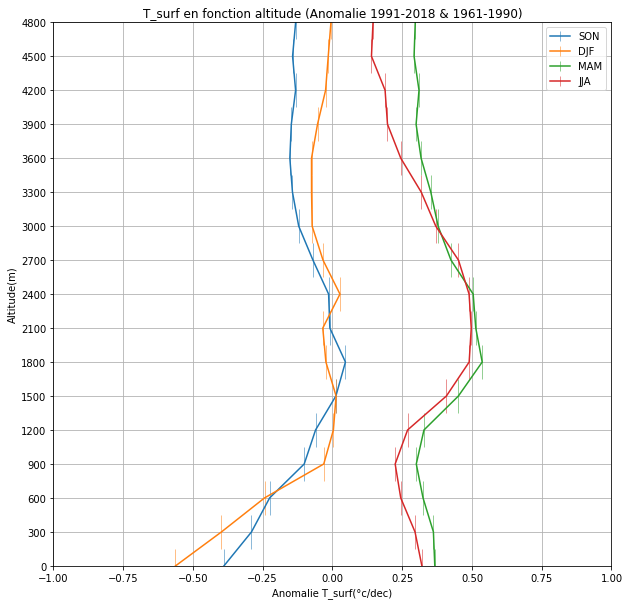

In [10]:
########################
### Analyse du Tair  ###
########################


### 1er FIG : altitudes/régions = f(tair) avec STD sur années ###
    
linestyle = ['-',':']
fig, ax = plt.subplots(figsize=(10,10))


for j in range(0,2):
    
    x = data_per_x(data_season,'ZS',all_ZS,all_ZS,file_extra)
    x = x[1].sel(year = slice(yr_1[j],yr_2[j]))
    
    for i in x.season:
        ax.step(x.mean(dim='year').sel(season = i),x.ZS+150, where='mid', linestyle = linestyle[j],linewidth=2)
        ax.legend(x.season.values,loc='lower right')
        ax.set_ylabel('Altitude(m)')

        ax.set_xlabel('T_surf(°c)')
        ax.set_title('T_surf en fonction altitude')
        ax.set_xlim(-25,25)
        ax.set_ylim(0,4800)

        ax.fill_betweenx(x.ZS+150,
             x.mean(dim='year').sel(season=i)+x.std(dim = 'year').sel(season=i),
             x.mean(dim='year').sel(season=i)-x.std(dim = 'year').sel(season=i),
            alpha = 0.1)
        ax.set_yticks(x.ZS)
        
lines = ax.get_lines()
legend1 = plt.legend([lines[k] for k in [0,5]], [str(yr_1[0])+'-'+str(yr_2[0]),str(yr_1[1])+'-'+str(yr_2[1])], loc="upper left")
legend2 = plt.legend([lines[k] for k in [0,1,2,3]], ['SON','DJF','MAM','JJA'], loc='lower right')
ax.add_artist(legend1)
ax.add_artist(legend2) 

### 1er FIG : ANOMALIE altitudes/régions = f(Tair) ###


x = data_per_x(data_season,'ZS',all_ZS,all_ZS,file_extra)
x_1 = x[1].sel(year=slice(yr_11,yr_12)).mean(dim='year')
x_2 = x[1].sel(year=slice(yr_21,yr_22)).mean(dim='year')
diff = (x_2 - x_1)/2.9

plt.figure(figsize=(10,10))

for i in range(0,4):
    plt.errorbar(diff.isel(season = i),x[1].ZS, yerr=150,elinewidth = (0.5))
    plt.legend(x[1].season.values)
    plt.yticks(x[1].ZS)
    plt.ylabel('Altitude(m)')

    plt.xlabel('Anomalie T_surf(°c/dec)')
    plt.title('T_surf en fonction altitude (Anomalie 1991-2018 & 1961-1990)')
    plt.xlim(-1,1)
    plt.ylim(0,4800)
plt.grid()




[Text(0.5, 0, 'Month')]

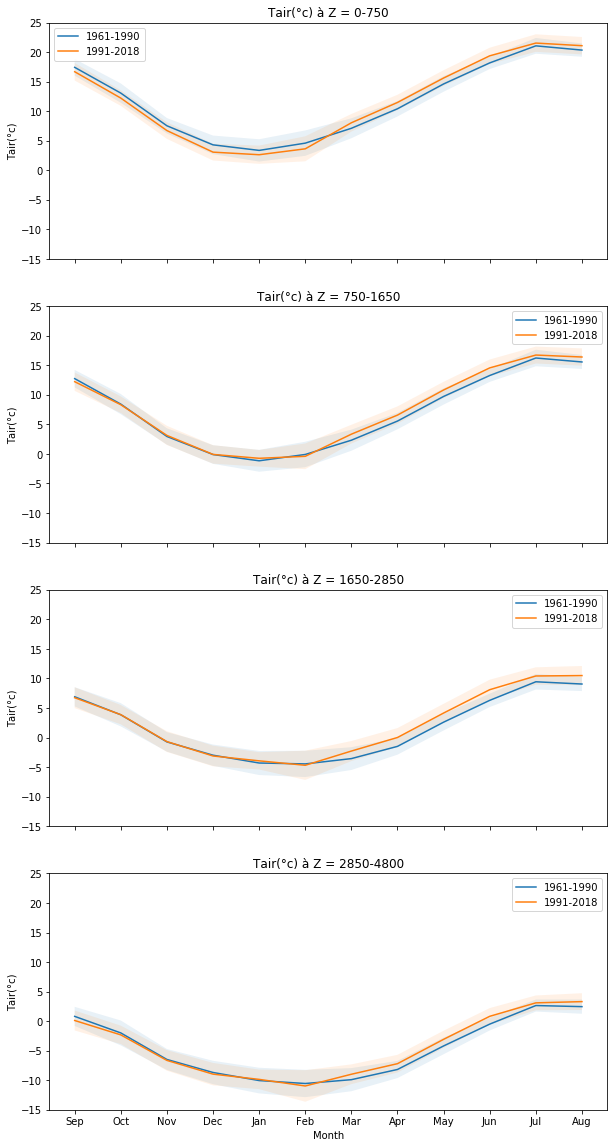

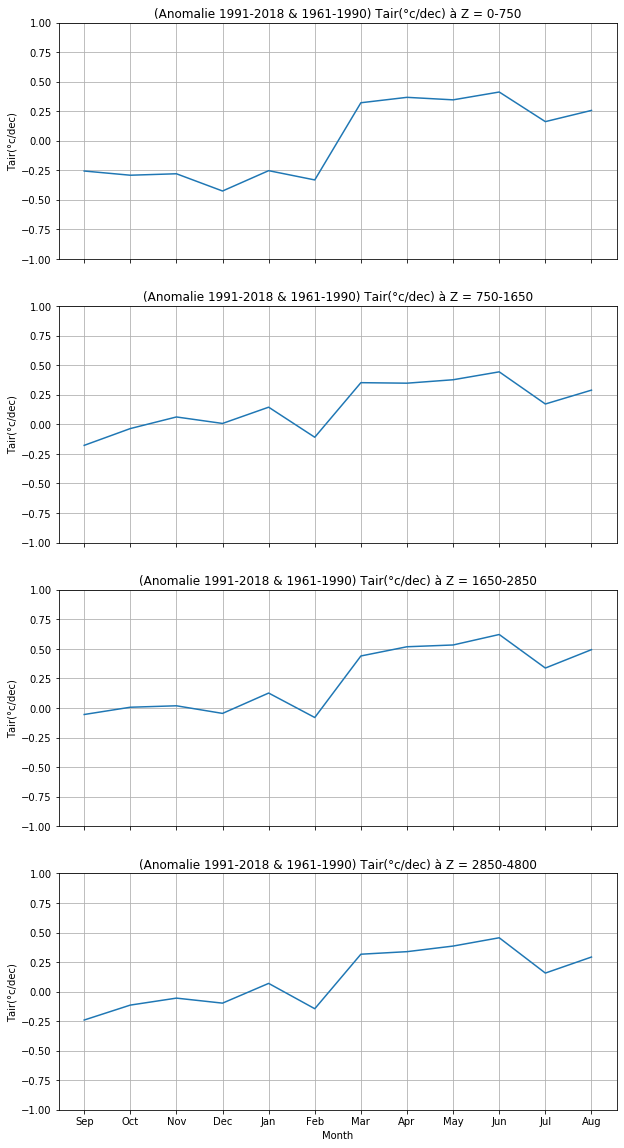

In [12]:
### 3eme FIG : Tair = f(months) + ZS ### AVEC ANOMALIE

x = data_per_x(data_month,'ZS',range_ZS,range_ZS_name,file_extra)


x_1 = x[1].sel(year=slice(yr_11,yr_12)).mean(dim='year')
x_2 = x[1].sel(year=slice(yr_21,yr_22)).mean(dim='year')

std_1 = x[1].sel(year=slice(yr_11,yr_12)).std(dim='year')
std_2 = x[1].sel(year=slice(yr_21,yr_22)).std(dim='year')
   
fig, ax = plt.subplots(len(x_1.ZS), sharex='col', figsize=(10,20))

for i in range(0,len(range_ZS)):
    ax[i].plot(x_1.month,x_1.isel(ZS = i),label=(str(yr_11)+'-'+str(yr_12)))
    ax[i].plot(x_1.month,x_2.isel(ZS = i),label=(str(yr_21)+'-'+str(yr_22)))
    ax[i].set(ylabel='Tair(°c)',
    title= 'Tair(°c) à Z = '+range_ZS_name[i])
    ax[i].legend()
    ax[i].fill_between(x[1].month,
                 x_1.isel(ZS = i)+std_1.isel(ZS = i),
                 x_1.isel(ZS = i)-std_1.isel(ZS = i),alpha = 0.1)

    ax[i].fill_between(x[1].month,
                 x_2.isel(ZS = i)+std_2.isel(ZS = i),
                 x_2.isel(ZS = i)-std_2.isel(ZS = i),alpha = 0.1)

    ax[i].set_ylim([-15,25])

ax[i].set(xlabel='Month')


diff = (x_2 - x_1)/2.9

fig, ax = plt.subplots(len(x[1].ZS), sharex='col', figsize=(10,20))

for i in range(0,len(range_ZS)):
    ax[i].plot(x[1].month,diff.isel(ZS = i))
    ax[i].set(ylabel='Tair(°c/dec)',
    title= '(Anomalie 1991-2018 & 1961-1990) Tair(°c/dec) à Z = '+range_ZS_name[i])
    ax[i].set_ylim([-1,1])
    ax[i].grid()
ax[i].set(xlabel='Month')

[Text(0.5, 0, 'Month')]

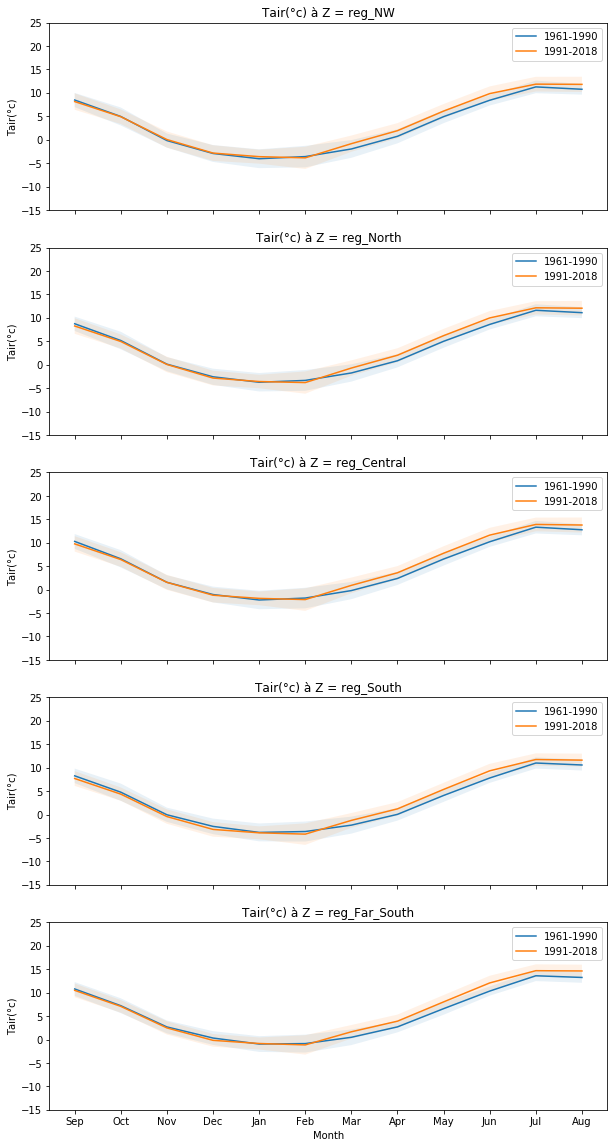

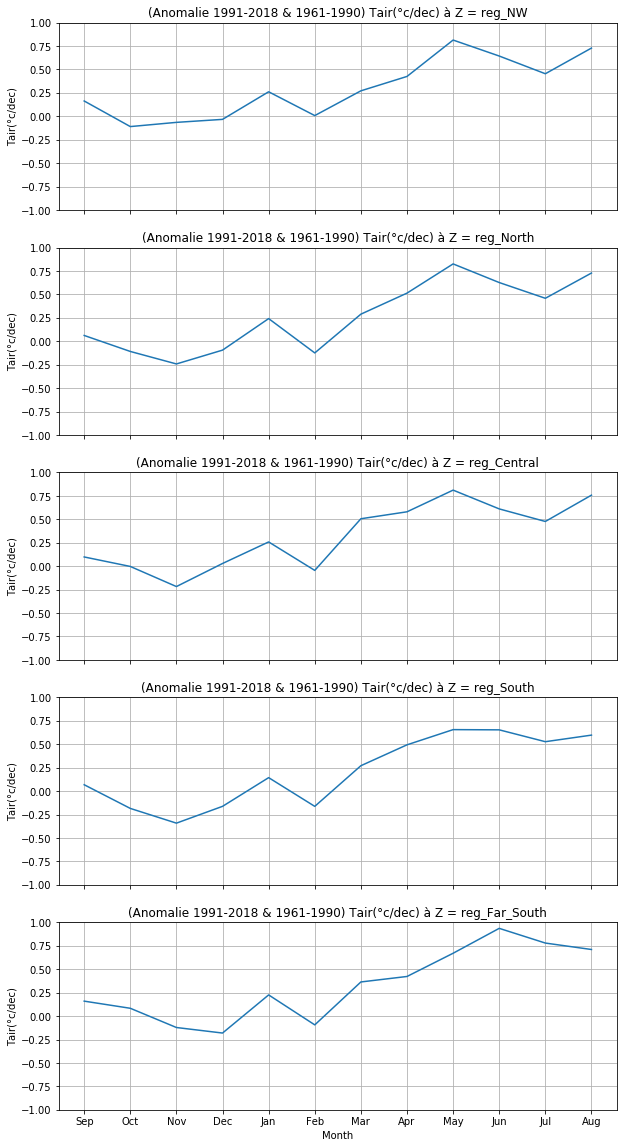

In [56]:
# ### 3eme FIG : Tair = f(months) + reg ### AVEC ANOMALIE

# x = data_per_x(data_month,'massif_number',all_reg,all_reg_name,file_extra)


# x_1 = x[1].sel(year=slice(yr_11,yr_12)).mean(dim='year')
# x_2 = x[1].sel(year=slice(yr_21,yr_22)).mean(dim='year')

# std_1 = x[1].sel(year=slice(yr_11,yr_12)).std(dim='year')
# std_2 = x[1].sel(year=slice(yr_21,yr_22)).std(dim='year')
   
# fig, ax = plt.subplots(len(x_1.massif_number), sharex='col', figsize=(10,20))

# for i in range(0,len(all_reg)):
#     ax[i].plot(x_1.month,x_1.isel(massif_number = i),label=(str(yr_11)+'-'+str(yr_12)))
#     ax[i].plot(x_1.month,x_2.isel(massif_number = i),label=(str(yr_21)+'-'+str(yr_22)))
#     ax[i].set(ylabel='Tair(°c)',
#     title= 'Tair(°c) à Z = '+all_reg_name[i])
#     ax[i].legend()
#     ax[i].fill_between(x[1].month,
#                  x_1.isel(massif_number = i)+std_1.isel(massif_number = i),
#                  x_1.isel(massif_number = i)-std_1.isel(massif_number = i),alpha = 0.1)

#     ax[i].fill_between(x[1].month,
#                  x_2.isel(massif_number = i)+std_2.isel(massif_number = i),
#                  x_2.isel(massif_number = i)-std_2.isel(massif_number = i),alpha = 0.1)

#     ax[i].set_ylim([-15,25])

# ax[i].set(xlabel='Month')


# diff = (x_2 - x_1)/2.9

# fig, ax = plt.subplots(len(x[1].massif_number), sharex='col', figsize=(10,20))

# for i in range(0,len(all_reg)):
#     ax[i].plot(x[1].month,diff.isel(region=i))
#     ax[i].set(ylabel='Tair(°c/dec)',
#     title= '(Anomalie 1991-2018 & 1961-1990) Tair(°c/dec) à Z = '+all_reg_name[i])
#     ax[i].set_ylim([-1,1])
#     ax[i].grid()
# ax[i].set(xlabel='Month')